In [3]:
import numpy as np
import matplotlib.pyplot as plt

Inizialize some useful quantities:
1. expected magnetic field decay on average: **mufdecay**
2. standard deviation of the magnetic field drift: **sigfdecay**
3. typical period between runs

In [8]:
expfdecay = [ i/3600 for i in [74,72.5,74.4,71.3]] # kHz / s
print("expected magnetic field decay in kHz/seconds" , expfdecay)
mufdecay = np.mean(expfdecay)
print("mean decay of the magnetic field: ", mufdecay)
sigfdecay = np.std(expfdecay)
print(f'%f +/- %f'%(mufdecay,sigfdecay))

# typical period between runs: 1h30' to 1h75'
tdecaymin = 3600* 1.5  # in s
tdecaymax = 3600* 1.75 # in s
tdecaysig = 5*60 # in s

expected magnetic field decay in kHz/seconds [0.020555555555555556, 0.02013888888888889, 0.020666666666666667, 0.019805555555555555]
mean decay of the magnetic field:  0.020291666666666666
0.020292 +/- 0.000343


In [10]:
### START TRIAL 
nruns = 1
wait0 = 320  # s, every other run 
tdwell = 8  # s
nstepssw = 24
nstepscl = 16
fstep = 5   # kHz
pretrigger_min = 0.25*nstepssw*fstep # kHz
pretrigger_max = 0.45*nstepssw*fstep # kHz
print("pretrigger: ", pretrigger_min, pretrigger_max)

# signal and background stat 
nuS = 100   # N
rateB = 0.5 # Hz

hfscpt = 1420405.75 # kHz (published measurement uncertainty: 500 kHz; ECR uncertainty: 100 kHz)
fbc0 =   28344100.00 # kHz = 28.3 GHz

pretrigger:  30.0 54.0


In [4]:
hfs = hfscpt + np.random.uniform(-20,40)
fad0 = fbc0 + hfs
fdecay = np.random.normal(mufdecay,sigfdecay)
    
# !!! after setting the window there is still a variation due to further decay while the sweep is ongoing
# !!! this should cancel out in the difference (does it?) if hfs = hfscpt, otherwise it cancels only partially 
# !!! it should be a dilution effect: if hfs>hfscpt (hfs<hfscpt) , then ad decays more (less), and the measured hfs is smaller than true hfs, so it gets closer to hfscpt in both cases (check)
# !!! dilution is (check): exphfs-hfscpt = (hfs-hfscpt)-(hfs-hfscpt)/fstep*tdwell*mufdecay = (hfs-hfscpt)*(1-1/fstep*tdwell*mufdecay) = (hfs-hfscpt)*D
D = (1-1/fstep*tdwell*mufdecay)
print("dilution (series-dependent) = ",D)

dilution (series-dependent) =  0.9675333333333334


In [21]:
lineshape_length_limit = 300 # kHz. Really a lot. Only used in intermediate steps. 

def lineshape(x,offset):

    frise = 40
    ffall = 120
    
    xp = x-offset-frise
    
    if (xp<0):
        y=1+xp/frise
    else :
        y=1-xp/ffall
    
    if (y<0):
        y=0
    
    return y


def piecewise(x,func,bins):
    
    return func(bins[np.max(np.argwhere(x>=bins))])


def accrej(fun, N, xmin, xmax, ymax=1):
    
    data = []
    num = 0
    Np = np.random.poisson(N)
    while (num < Np):
        x = np.random.uniform(xmin,xmax)
        y = np.random.uniform(0,ymax)
        if (y<fun(x)):
            data += [x]
            num +=1
    
    return data

In [96]:
tdecay=0
for i in range(nruns):
    
    wait = wait0 * i%2
    
    tinterval = 0
    if (i>0):
        tinterval = np.random.uniform(tdecaymin,tdecaymax)
    
    tdecay += tinterval
    bcdelay = tdecay + wait 
    addelay = bcdelay + tdwell*(nstepssw+nstepscl)
    # neglecting further decay after the start of the sweep; see dilution effect discussed above (systematic uncertainty)
    
    fbc = fbc0 - mufdecay*bcdelay
    fad = fad0 - mufdecay*addelay
    
    # now can define lineshape 
    line_bc = lambda f : lineshape(f,offset=fbc)
    line_ad = lambda f : lineshape(f,offset=fad)
       
    # the operator now sets the windows 
    # special treatment for the first run (ECR based + low stat attempts)
    if (i==0):
        pretrigger = np.random.uniform(pretrigger_min,pretrigger_max)
        bcwin_start0 = fbc0 - pretrigger

    # tdecay estimated by operator (overrides ECR)
    meastdecay = tdecay + np.random.normal(0,tdecaysig)
    
    # assuming there's no uw-frequency jitter . calibration and reproducibility are "perfect"
    
    step_limit = int(np.floor(lineshape_length_limit/fstep))
    
    bcwin_start = bcwin_start0 - meastdecay*fdecay     
    adwin_start = bcwin_start + hfscpt

    # now can build linspaces for generation 
    ticks_bc = np.linspace(bcwin_start,bcwin_start + step_limit*fstep,step_limit+1)
    ticks_ad = np.linspace(adwin_start,adwin_start + step_limit*fstep,step_limit+1)

    pdf_bc = lambda f : piecewise(f,line_bc,ticks_bc)
    pdf_ad = lambda f : piecewise(f,line_ad,ticks_ad)

    # the actual histograms in the time domain
    bins_bc = np.linspace(0,tdwell*nstepssw,nstepssw+1) 
    bins_ad = np.linspace(0,tdwell*nstepssw,nstepssw+1) 
    freq_bc = ticks_bc[:len(bins_bc)] # to keep track of the relationship between times and frequencies
    freq_ad = ticks_ad[:len(bins_ad)]

    
    # now can sample lineshapes    
    data_bc = accrej(pdf_bc,nuS,ticks_bc[0],ticks_bc[-1])
    signal_bc,_ = np.histogram(data_bc,ticks_bc)
    hS_bc = signal_bc[:nstepssw]
    overflow_bc = np.sum(signal_bc[nstepssw:])
    # add cosmics background 
    hB_bc = [ np.random.poisson(rateB*tdwell) for i in hS_bc]
    hist_bc = hS_bc + hB_bc
    
    data_ad = accrej(pdf_ad,nuS,ticks_ad[0],ticks_ad[-1])
    signal_ad,_ = np.histogram(data_ad,ticks_ad)
    hS_ad = signal_ad[:nstepssw]
    overflow_ad = np.sum(signal_ad[nstepssw:])
    # add cosmics background 
    hB_ad = [ np.random.poisson(rateB*tdwell) for i in hS_ad]
    hist_ad = hS_ad + hB_ad
    
    


    

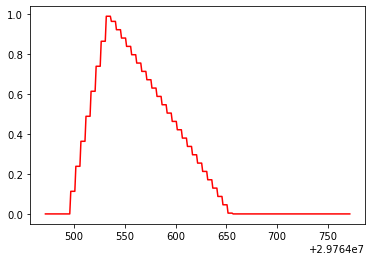

In [64]:
x = np.linspace(ticks_ad[0], ticks_ad[-1], 300+1)
y = [ pdf_ad(f) for f in x ]
plt.plot(x, y, color='red')

<BarContainer object of 24 artists>

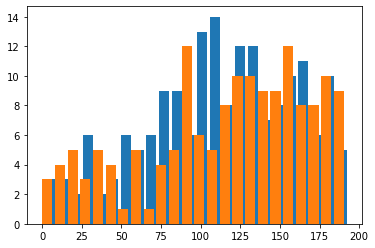

In [93]:
fbar = 0.8

bwid=(bins_ad[1]-bins_ad[0])
plt.bar((bins_ad[1:]+bins_ad[:-1])*0.5+bwid*(1-fbar)/2,hist_ad,bwid*fbar)

bwid=(bins_bc[1]-bins_bc[0])
plt.bar((bins_bc[1:]+bins_bc[:-1])*0.5-bwid*(1-fbar)/2,hist_bc,bwid*fbar)

<BarContainer object of 24 artists>

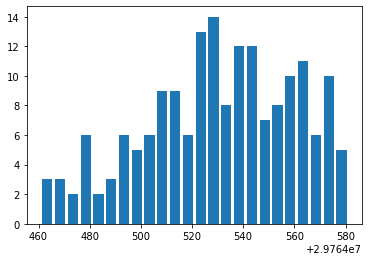

In [92]:
fbar = 0.8

bwid=(freq_ad[1]-freq_ad[0])
plt.bar((freq_ad[1:]+freq_ad[:-1])*0.5,hist_ad,bwid*fbar)


<BarContainer object of 24 artists>

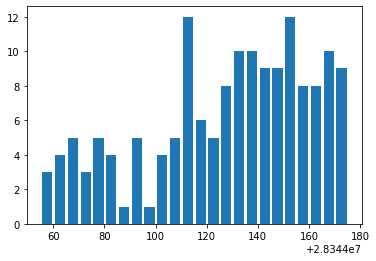

In [91]:
bwid=(freq_bc[1]-freq_bc[0])
plt.bar((freq_bc[1:]+freq_bc[:-1])*0.5,hist_bc,bwid*fbar)

In [94]:
24*8

192